# ECMWF AIFS forecast

## Overview

This notebook demonstrates how to:
1. Connect to the ECMWF Open Data API
2. Download operational forecast data from the AI-based Integrated Forecast System (AIFS)
3. Process and visualize the forecast data
4. Save the data for further analysis

**Note:** No API key is required for ECMWF Open Data!

## 2. Import Required Libraries

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from ecmwf.opendata import Client

from plot import plot_variable

## 3. Configure the ECMWF Client

We'll set up the client to access ECMWF's AIFS (Artificial Intelligence Forecasting System) operational forecasts. This model is operational since 25 February of 2025.

In [2]:
client = Client(
    "ecmwf", 
    model="aifs-single",  # ECMWF's AI-based Integrated Forecast System
    resol="0p25",         # 0.25 degree resolution (~28 km)
)

print(f"✓ Client configured for model: {client.model}")

✓ Client configured for model: aifs-single


## 4. Define Configuration Parameters

Set up the region of interest, variables to download, and forecast steps.

In [3]:
var_dict = {
    'ssrd': 'ssrd',   # Surface solar radiation downwards
    # '100u': 'u100',   # 100m u-component of wind
    # '100v': 'v100',   # 100m v-component of wind
}

In [4]:
area_bbox = [18, 32, -5, 52]  # East Africa region

# Parameters to download
parameters = ['ssrd'] # , '100u', '100v']  # Wind components at 100m height

# Forecast steps (in hours, 6-hourly intervals up to 360 hours = 15 days)
steps = list(range(0, 361, 6))

# Output directory
oper_out_dir = Path("data/AIFS/output")
oper_out_dir.mkdir(parents=True, exist_ok=True)

## 5. Download Forecast Data

Now we'll download the operational forecast data for each parameter. This may take a few minutes depending on your connection.

In [ ]:
for param in parameters:

    print(f"Downloading parameter: {param} ({var_dict.get(param, param)})")
    
    filename = 'tmp_oper.nc'
    
    # Retrieve operational forecast from latest run
    print("Retrieving data from ECMWF...")
    client.retrieve(
        date=0,           # Latest available date (0 = today)
        time=0,           # 00z run (can also use 6, 12, or 18 for other runs)
        step=steps,       # Forecast steps: 0, 6, 12, ..., 360 hours
        stream="oper",    # Operational high-resolution forecast
        type="fc",        # Forecast type
        levtype="sfc",    # Surface level
        param=param,      # Parameter to download
        target=filename   # Temporary file
    )
    print(f"Data downloaded to {filename}")
    
    # Open the downloaded NetCDF file
    print("Loading dataset...")
    ds = xr.open_dataset(filename, engine="cfgrib")
    
    # Convert step to timedelta and extract region
    ds['step'] = pd.to_timedelta(ds.step.values)
    ds = ds.sel(
        latitude=slice(area_bbox[0], area_bbox[2]), 
        longitude=slice(area_bbox[1], area_bbox[3])
    )
    
    # Get forecast initialization time
    forecast_datetime = ds.time.values
    forecast_datetime_str = pd.to_datetime(forecast_datetime).strftime("%Y%m%d%H%M%S")
    
    print(f"Forecast run time: {pd.to_datetime(forecast_datetime)}")
    print(f"Dataset shape: {ds[var_dict[param]].shape}")
    print(f"Time steps: {len(ds.step.values)}")
    
    # Save the extracted dataset
    out_fname = oper_out_dir / f'{forecast_datetime_str}-{steps[-1]}h_{param}.nc'
    ds.to_netcdf(out_fname)
    print(f"Saved to: {out_fname}")
    
    # Clean up temporary file
    Path(filename).unlink(missing_ok=True)




## 6. Visualize the Forecast

Let's load one of the downloaded files and visualize a specific forecast step.

In [5]:
# Find the most recent forecast file
forecast_files = list(Path("data/AIFS/output").glob("*_ssrd.nc"))
latest_file = forecast_files[-0]

print("File: {}".format(latest_file.name))

print(f"Loading: {latest_file.name}")

# Open the dataset
ds_viz = xr.open_dataset(latest_file, engine="netcdf4")

# Get variable name and forecast time
param_code = latest_file.name.split('_')[-1].replace('.nc', '')
var_name = var_dict.get(param_code, param_code)
forecast_time = pd.to_datetime(ds_viz.time.values)

print(f"Variable: {var_name}")
print(f"Forecast time: {forecast_time}")
print(f"Available steps: {len(ds_viz.step)} ({ds_viz.step.values[0]} to {ds_viz.step.values[-1]})")


File: 20251105000000-360h_ssrd.nc
Loading: 20251105000000-360h_ssrd.nc
Variable: ssrd
Forecast time: 2025-11-05 00:00:00
Available steps: 61 (0 nanoseconds to 1296000000000000 nanoseconds)
Variable: ssrd
Forecast time: 2025-11-05 00:00:00
Available steps: 61 (0 nanoseconds to 1296000000000000 nanoseconds)


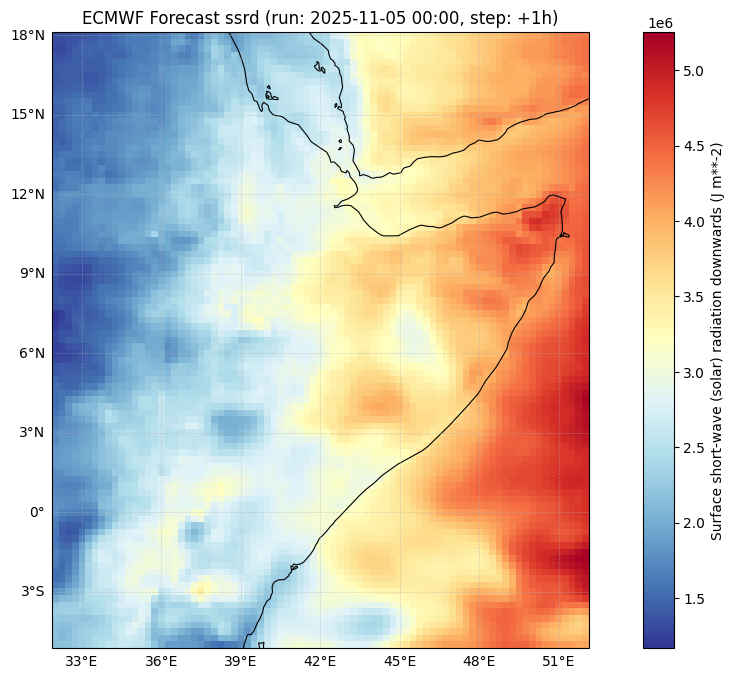

In [6]:
# Plot forecast at +48 hours (2 days ahead)
if forecast_files:
    step_index = 1
    
    plot_variable(
        ds_viz, 
        var_name, 
        forecast_datetime_str=forecast_time.strftime("%Y-%m-%d %H:%M"), 
        step=step_index,
        figsize=(14, 8),
        cmap='RdYlBu_r'
    )

## 7. Compare solar forecast with climatology (next 14 days)

✓ Forecast file loaded: 20251105000000-360h_ssrd.nc
  Forecast initialization: 2025-11-05 00:00 UTC
  Number of steps: 61
  Step interval: 21600000000000 nanoseconds


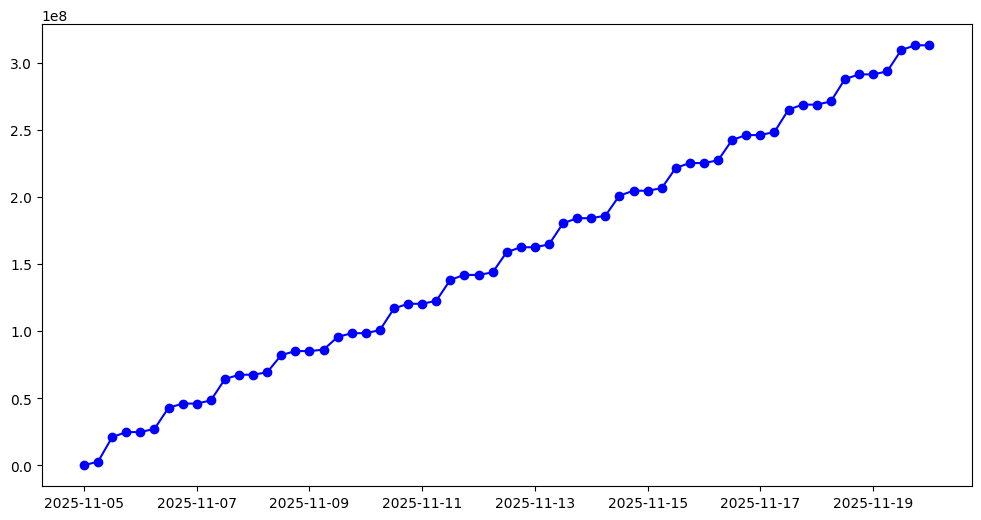

In [88]:
# Select a location (e.g., Nairobi, Kenya: -1.28°N, 36.82°E)
location_name = "Nairobi, Kenya"
lat_point = -1.28
lon_point = 36.82

# Load AIFS forecast data
forecast_ssrd_file = list(Path("data/AIFS/output").glob("*_ssrd.nc"))[-1]
forecast_ds = xr.open_dataset(forecast_ssrd_file, engine="netcdf4")

print(f"✓ Forecast file loaded: {forecast_ssrd_file.name}")
print(f"  Forecast initialization: {pd.to_datetime(forecast_ds.time.values).strftime('%Y-%m-%d %H:%M UTC')}")
print(f"  Number of steps: {len(forecast_ds.step)}")
print(f"  Step interval: {forecast_ds.step.values[1] - forecast_ds.step.values[0]}")

# Extract forecast at location
forecast_location = forecast_ds['ssrd'].sel(
    latitude=lat_point, 
    longitude=lon_point, 
    method='nearest'
)

# plot forecast time series
plt.figure(figsize=(12, 6))
plt.plot(forecast_location.valid_time, forecast_location, marker='o', label='AIFS Forecast', color='blue')

In [58]:
# open climatology
# Select a location (e.g., Nairobi, Kenya: -1.28°N, 36.82°E)
location_name = "Nairobi, Kenya"
lat_point = -1.28
lon_point = 36.82

today = pd.Timestamp.now().normalize()

climatology_output_dir = Path("data/climatology")

# Load the solar radiation climatology
clim_ssrd_reload = xr.open_dataset(climatology_output_dir / "surface_solar_radiation_downwards_climatology.nc")

# Extract time series at the location
location_series = clim_ssrd_reload['ssrd'].sel(
    latitude=lat_point, 
    longitude=lon_point, 
    method='nearest'
).sel(dayofyear=slice(today.timetuple().tm_yday, today.timetuple().tm_yday + 14))

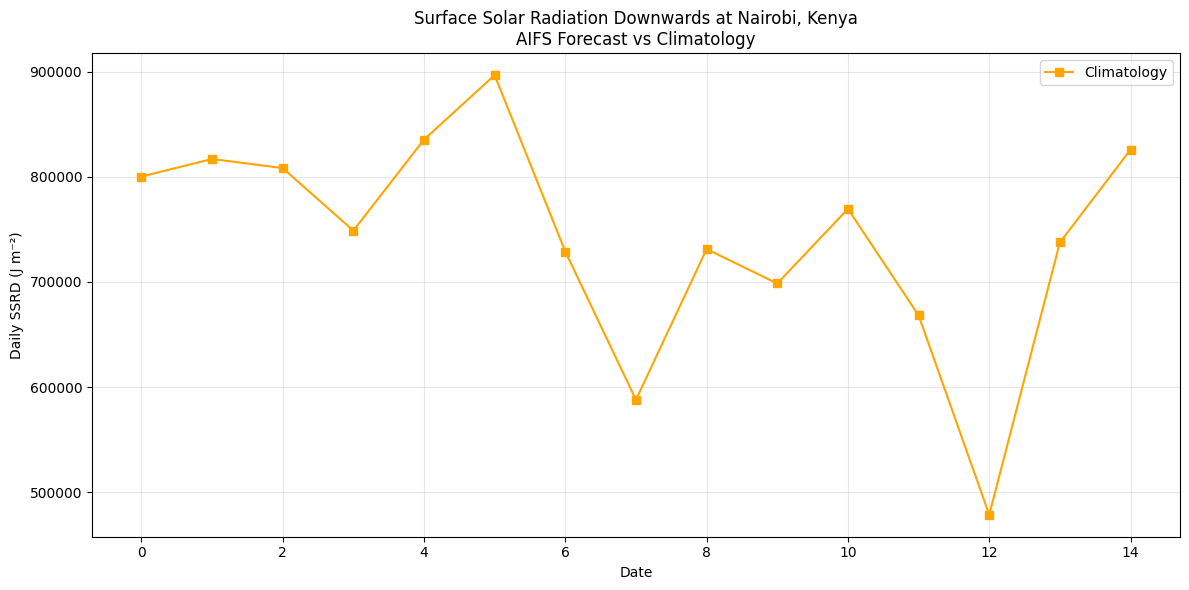

In [62]:
# plot AIFS forecast vs climatology
plt.figure(figsize=(12, 6))
# plt.plot(forecast_daily_energy.valid_time, forecast_daily_energy, marker='o', label='AIFS Forecast', color='blue')
plt.plot(location_series, marker='s', label='Climatology', color='orange')
plt.title(f"Surface Solar Radiation Downwards at {location_name}\nAIFS Forecast vs Climatology")
plt.xlabel("Date")
plt.ylabel("Daily SSRD (J m⁻²)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [51]:
clim_ssrd_reload

<xarray.Dataset> Size: 11MB
Dimensions:    (dayofyear: 366, latitude: 93, longitude: 81)
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
  * latitude   (latitude) float64 744B 18.0 17.75 17.5 17.25 ... -4.5 -4.75 -5.0
  * longitude  (longitude) float64 648B 32.0 32.25 32.5 ... 51.5 51.75 52.0
    number     int64 8B ...
Data variables:
    ssrd       (dayofyear, latitude, longitude) float32 11MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-31T23:10 GRIB to CDM+CF via cfgrib-0.9.1...

## Resources

- [ECMWF Open Data Documentation](https://data.ecmwf.int/forecasts/)
- [ECMWF Open Data API](https://confluence.ecmwf.int/display/DAC/ECMWF+open+data%3A+real-time+forecasts+from+IFS+and+AIFS)
- [Available Parameters](https://codes.ecmwf.int/grib/param-db/)
- [AIFS Information](https://www.ecmwf.int/en/about/media-centre/news/2025/ecmwfs-ai-forecasts-become-operational)